In [9]:
!pip install --upgrade scikit-learn xgboost


### Importing Necessary Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.pipeline import Pipeline
import warnings

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate

### Loading dataset and displaying the columns of the dataset

In [2]:
traffic_info = pd.read_csv('/content/traffic.csv')
traffic_info

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


### Dropping ID Column and Extracting Date Features

In [3]:
traffic_ID_dropped= traffic_info.drop(columns = ['ID'])
traffic_ID_dropped['DateTime'] = pd.to_datetime(traffic_ID_dropped['DateTime'])
traffic_flow = traffic_ID_dropped.assign(
    Year=traffic_ID_dropped['DateTime'].dt.year.astype('int'),
    Month=traffic_ID_dropped['DateTime'].dt.month.astype('int'),
    Date=traffic_ID_dropped['DateTime'].dt.day.astype('int'),
    Hour=traffic_ID_dropped['DateTime'].dt.hour.astype('int'),
    Day=traffic_ID_dropped['DateTime'].dt.dayofweek.astype('int')
)
traffic_flow

,DateTime,Junction,Vehicles,Year,Month,Date,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,6
1,2015-11-01 01:00:00,1,13,2015,11,1,1,6
2,2015-11-01 02:00:00,1,10,2015,11,1,2,6
3,2015-11-01 03:00:00,1,7,2015,11,1,3,6
4,2015-11-01 04:00:00,1,9,2015,11,1,4,6
...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,2017,6,30,19,4
48116,2017-06-30 20:00:00,4,30,2017,6,30,20,4
48117,2017-06-30 21:00:00,4,16,2017,6,30,21,4
48118,2017-06-30 22:00:00,4,22,2017,6,30,22,4


### Plotting Number of Vehicles at Each Junction for Each Year

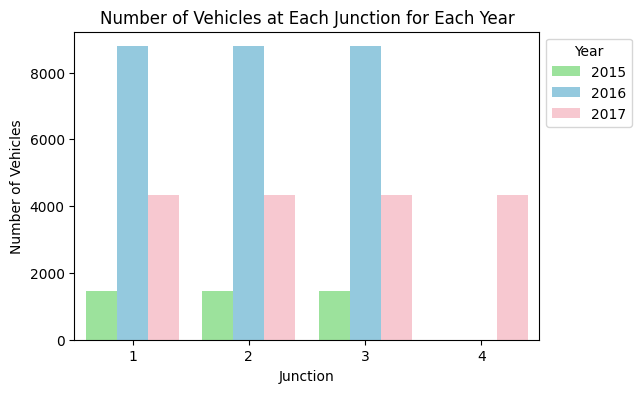

In [4]:
vehicle_counts = traffic_flow.groupby(['Year', 'Junction']).size().reset_index(name='VehicleCount')
plt.figure(figsize=(6, 4))
sns.barplot(data=vehicle_counts, x='Junction', y='VehicleCount', hue='Year', palette=["lightgreen", "skyblue", "pink"])
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles at Each Junction for Each Year')
plt.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Plotting Number of Vehicles vs Hour at Each Junction

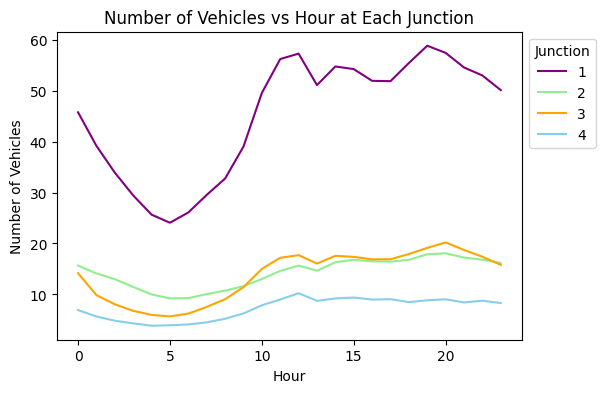

In [5]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=traffic_flow, x='Hour', y='Vehicles', hue='Junction', palette=["purple", "lightgreen", "orange", "skyblue"], errorbar=None)
plt.xlabel('Hour')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles vs Hour at Each Junction')
plt.legend(title='Junction', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Plotting Number of Vehicles vs Day at Each Junction

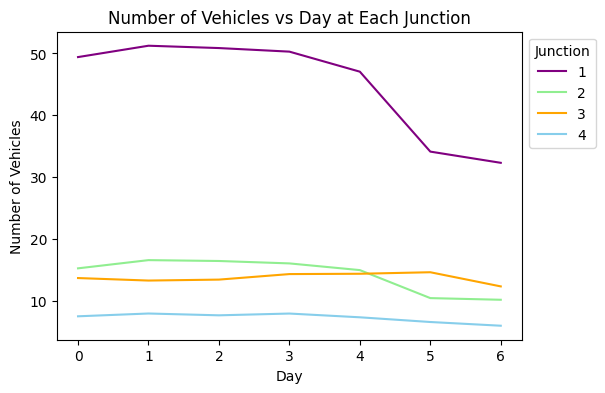

In [6]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=traffic_flow, x='Day', y='Vehicles', hue='Junction', palette=["purple", "lightgreen", "orange", "skyblue"], errorbar=None)
plt.xlabel('Day')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles vs Day at Each Junction')
plt.legend(title='Junction', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Plotting Vehicle Traffic Over Time for Each Junction

<ipython-input-7-e0c1cc83f5e0>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  junction_data_resampled = junction_data.set_index('DateTime').resample('H').sum()
<ipython-input-7-e0c1cc83f5e0>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  junction_data_resampled = junction_data.set_index('DateTime').resample('H').sum()
<ipython-input-7-e0c1cc83f5e0>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  junction_data_resampled = junction_data.set_index('DateTime').resample('H').sum()
<ipython-input-7-e0c1cc83f5e0>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  junction_data_resampled = junction_data.set_index('DateTime').resample('H').sum()


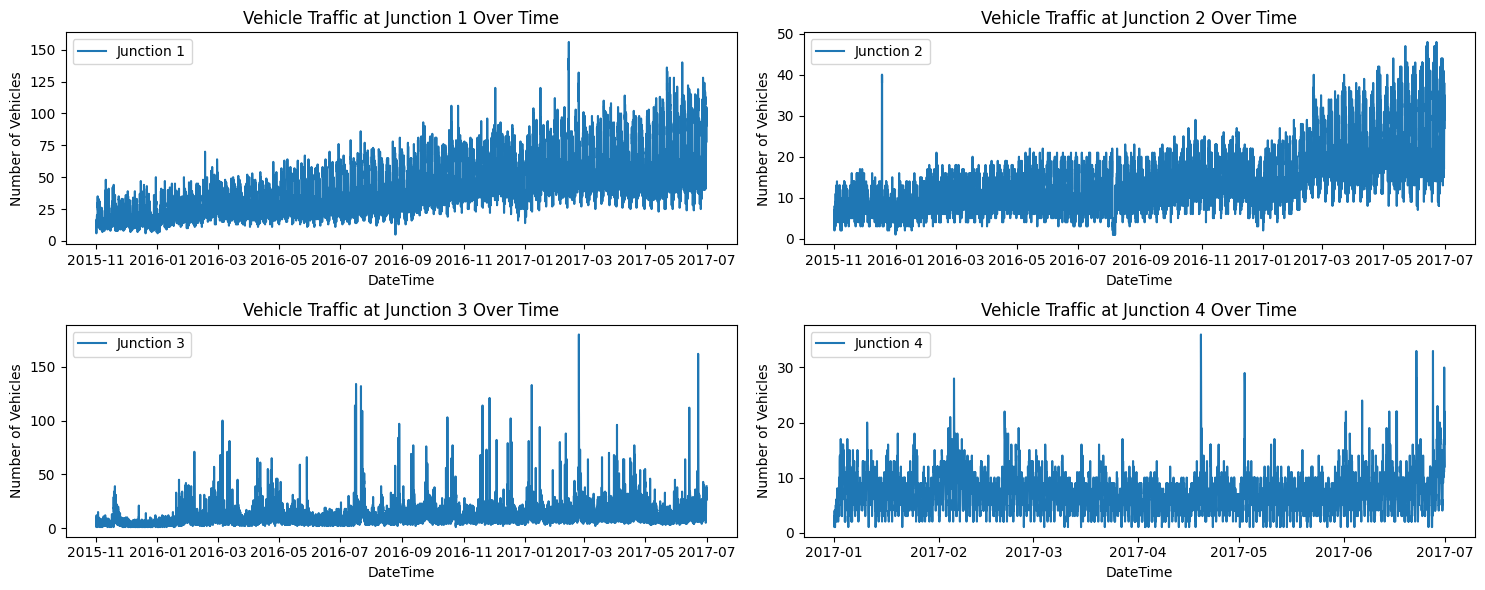

In [7]:
junctions = traffic_info['Junction'].unique()

plt.figure(figsize=(15, 6))
for junction in junctions:
    junction_data = traffic_info[traffic_info['Junction'] == junction].copy()

    junction_data['DateTime'] = pd.to_datetime(junction_data['DateTime'])
    plt.subplot(2, 2, junction)
    junction_data_resampled = junction_data.set_index('DateTime').resample('H').sum()
    plt.plot(junction_data_resampled.index, junction_data_resampled['Vehicles'], label=f'Junction {junction}')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Vehicles')
    plt.title(f'Vehicle Traffic at Junction {junction} Over Time')
    plt.legend()

plt.tight_layout()
plt.show()

### Training Regression Models for Predicting Traffic Flow Patterns

In [10]:
traffic_flow['DateTime'] = pd.to_numeric(traffic_flow['DateTime'])

X = traffic_flow.drop(columns=['Vehicles'])
y = traffic_flow['Vehicles']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_regressor = DecisionTreeRegressor(random_state=42)
rf_regressor = RandomForestRegressor(random_state=42)
xgb_regressor = XGBRegressor(random_state=42)

dt_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)

param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 7]}
best_score = float('inf')
best_params = {}

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        model = XGBRegressor(n_estimators=n, max_depth=d, random_state=42, objective='reg:squarederror')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = mean_squared_error(y_test, predictions)
        if score < best_score:
            best_score = score
            best_params = {'n_estimators': n, 'max_depth': d}

print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 150, 'max_depth': 7}


### Visualization of Actual vs Predicted Vehicles for Regression Models

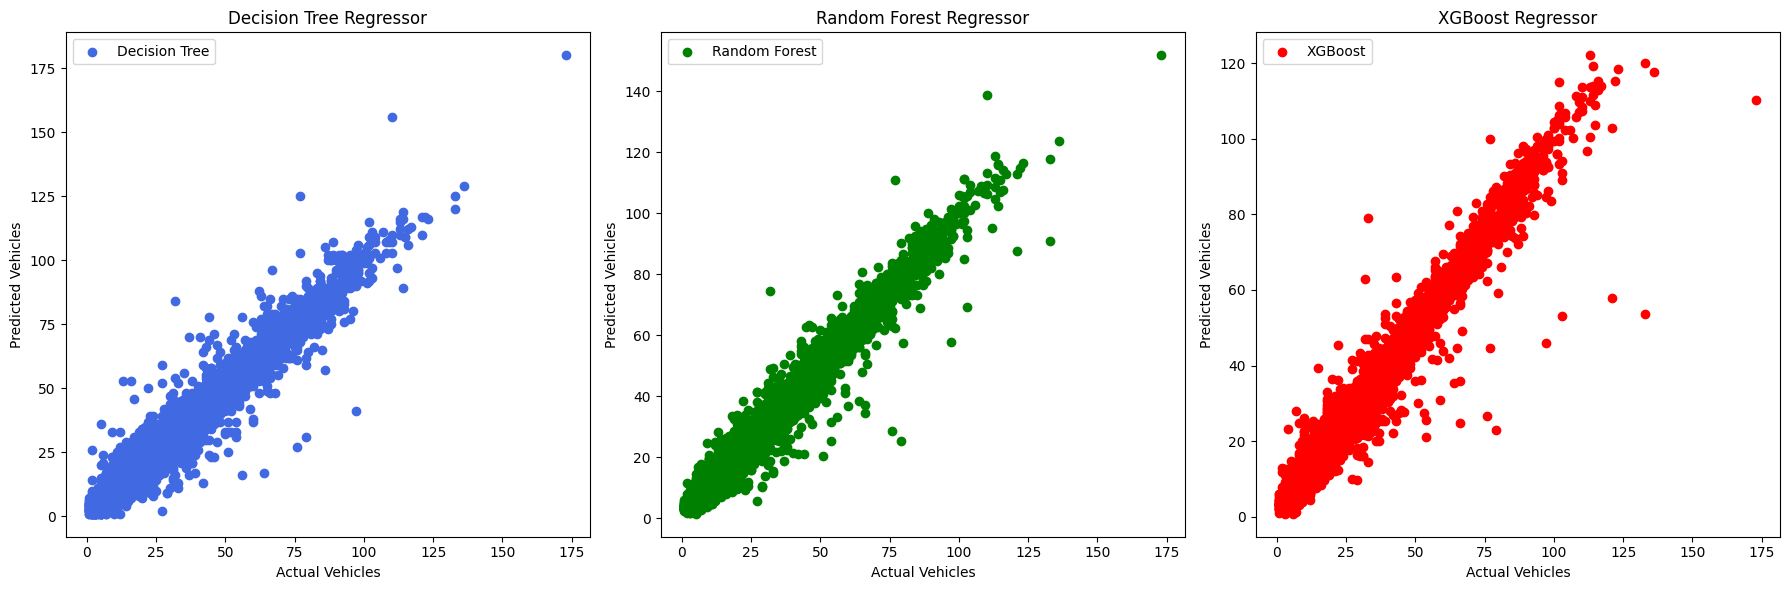

In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
best_xgb_regressor = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42,
    objective='reg:squarederror'
)
best_xgb_regressor.fit(X_train, y_train)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
y_pred_dt = dt_regressor.predict(X_test)
plt.scatter(y_test, y_pred_dt, color='royalblue', label='Decision Tree')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('Decision Tree Regressor')
plt.legend(loc='upper left')

plt.subplot(1, 3, 2)
y_pred_rf = rf_regressor.predict(X_test)
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('Random Forest Regressor')
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
y_pred_xgb = best_xgb_regressor.predict(X_test)
plt.scatter(y_test, y_pred_xgb, color='red', label='XGBoost')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('XGBoost Regressor')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Error Distribution Analysis for Regression Models

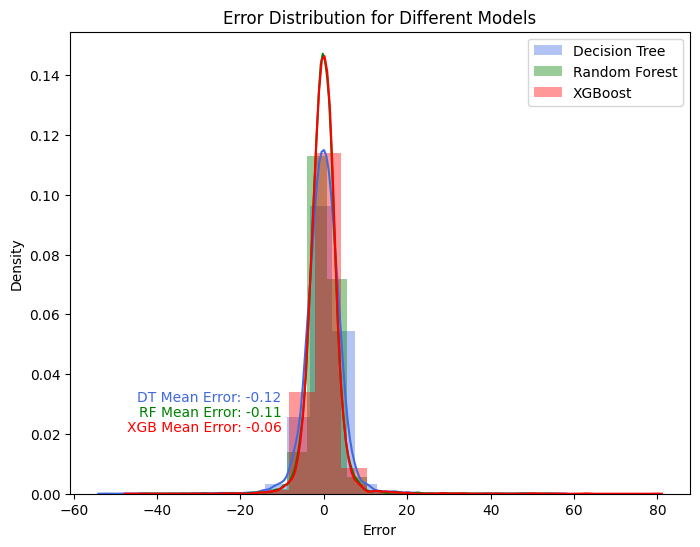

In [16]:
warnings.filterwarnings("ignore", category=UserWarning)

plt.figure(figsize=(8, 6))

sns.distplot(y_test - y_pred_dt, bins = 20, color='royalblue', label='Decision Tree', kde=True)

sns.distplot(y_test - y_pred_rf, bins = 20, color='green', label='Random Forest', kde=True)

sns.distplot(y_test - y_pred_xgb, bins = 20, color='red', label='XGBoost', kde=True)

plt.title('Error Distribution for Different Models')
plt.xlabel('Error')
plt.ylabel('Density')
plt.legend()

mean_error_dt = np.mean(y_test - y_pred_dt)
mean_error_rf = np.mean(y_test - y_pred_rf)
mean_error_xgb = np.mean(y_test - y_pred_xgb)

plt.text(mean_error_dt - 10, 0.03, f'DT Mean Error: {mean_error_dt:.2f}', verticalalignment='bottom', horizontalalignment='right', color='royalblue', fontsize=10)
plt.text(mean_error_rf - 10, 0.025, f'RF Mean Error: {mean_error_rf:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=10)
plt.text(mean_error_xgb - 10, 0.02, f'XGB Mean Error: {mean_error_xgb:.2f}', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=10)

plt.show()

### Comparison of MSE and R2 Scores for Regression Models

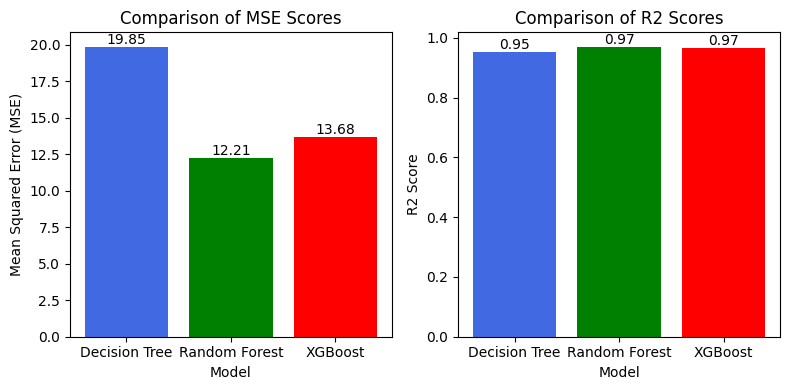

In [17]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
models = ['Decision Tree', 'Random Forest', 'XGBoost']
mse_scores = [mean_squared_error(y_test, y_pred_dt),
              mean_squared_error(y_test, y_pred_rf),
              mean_squared_error(y_test, y_pred_xgb)]
r2_scores = [r2_score(y_test, y_pred_dt),
             r2_score(y_test, y_pred_rf),
             r2_score(y_test, y_pred_xgb)]
mse_bars = plt.bar(models, mse_scores, color=['royalblue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE Scores')
plt.xticks(models)

for i, bar in enumerate(mse_bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f'{mse_scores[i]:.2f}', ha='center', va='bottom', wrap=True)

plt.subplot(1, 2, 2)
r2_bars = plt.bar(models, r2_scores, color=['royalblue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Comparison of R2 Scores')
plt.xticks(models)

for i, bar in enumerate(r2_bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f'{r2_scores[i]:.2f}', ha='center', va='bottom', wrap=True)

plt.tight_layout()
plt.show()

### Model Performance Scores on Train and Test Data

In [18]:
models = ['Decision Tree', 'Random Forest', 'XGBoost']
train_scores = [dt_regressor.score(X_train, y_train), rf_regressor.score(X_train, y_train), best_xgb_regressor.score(X_train, y_train)]
test_scores = [dt_regressor.score(X_test, y_test), rf_regressor.score(X_test, y_test), best_xgb_regressor.score(X_test, y_test)]

table = [['Model', 'Training Score', 'Test Score']]
for model, train_score, test_score in zip(models, train_scores, test_scores):
    table.append([model, train_score, test_score])

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤══════════════════╤══════════════╕
│ Model         │   Training Score │   Test Score │
╞═══════════════╪══════════════════╪══════════════╡
│ Decision Tree │         1        │     0.951287 │
├───────────────┼──────────────────┼──────────────┤
│ Random Forest │         0.995275 │     0.97004  │
├───────────────┼──────────────────┼──────────────┤
│ XGBoost       │         0.982204 │     0.966432 │
╘═══════════════╧══════════════════╧══════════════╛
